# Table of Contents


* **Geting Started**
* **Resampling**
* **Decorators**

Note: this notebook is meant to be a demo of some of the capabilities of **`oo-learning`** (https://github.com/shane-kercheval/oo-learning); it is not meant to show the best approach to exploring/cleaning/modeling this particular dataset. Also, with most graphs (e.g. correlations/box-plots/etc.) I will spend very little time commenting on the significance of any interesting or patterns. Again, the intent is to show a demo, not a guide to data analysis. 

# Getting Started

In this notebook, we'll see how to do 'repeated cross-validation' via **`RepeatedCrossValidationResampler`** class.

## Set Up Environment

In [1]:
# !pip install oolearning --upgrade

In [2]:
from oolearning import *
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

## Import Data

`ExploreClassificationDataset` is a convenience class described in the [first notebook of this series](https://github.com/shane-kercheval/oo-learning/blob/master/examples/classification-titanic/1-Exploring%20the%20Titanic%20Dataset.ipynb).

In [3]:
csv_file = '../data/titanic.csv'
target_variable = 'Survived'
target_mapping = {0: 'died', 1: 'lived'}  # so we can convert from numeric to categoric

explore = ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                target_variable=target_variable,
                                                map_numeric_target=target_mapping)

In [4]:
explore.dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,died,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,lived,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,lived,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,lived,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,died,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Resampling

A Resampler is an object that defines how to 'resample' a data set, for example 'repeated cross-validation', and provides information about the performance of the model fit on the resampled data.

In [5]:
# separate the features from the target variable
data_x = explore.dataset.drop(columns='Survived')
data_y = explore.dataset.Survived

# define the transformations
transformations = [RemoveColumnsTransformer(['PassengerId', 'Name', 'Ticket', 'Cabin']),
                   CategoricConverterTransformer(['Pclass', 'SibSp', 'Parch']),
                   ImputationTransformer(),
                   DummyEncodeTransformer(CategoricalEncoding.ONE_HOT)]

# define the scores, which will be used to compare the performance of each fold and overall
# the scores need a Converter, which contains the logic necessary to convert the predicted values to a predicted class.
score_list = [AucRocScore(positive_class='lived'),
              KappaScore(converter=TwoClassThresholdConverter(threshold=0.5, positive_class='lived')),
              SensitivityScore(converter=TwoClassThresholdConverter(threshold=0.5, positive_class='lived')),
              SpecificityScore(converter=TwoClassThresholdConverter(threshold=0.5, positive_class='lived')),
              ErrorRateScore(converter=TwoClassThresholdConverter(threshold=0.5, positive_class='lived'))]

# define & configure the Resampler object
resampler = RepeatedCrossValidationResampler(
    model=RandomForestClassifier(),  # we'll use a Random Forest model
    transformations=transformations,
    scores=score_list,
    folds=5,  # 5 folds with 5 repeats
    repeats=5)

# resample
resampler.resample(data_x=data_x, data_y=data_y, hyper_params=RandomForestHP())  # default Random Forest Hyper Parameters

We can look in the **`results`** property of the **`Resampler`** object to access various information, such as the cross validation scores, below.

There should be 1 row for each fold, multiplied by the number of repeats, so 25 rows; with each column corresponding to the Score objects that were passed in as a list to the Resampler.

In [6]:
resampler.results.resampled_scores

,AUC_ROC,kappa,sensitivity,specificity,error_rate
0,0.880159,0.598479,0.736111,0.857143,0.192090
1,0.858232,0.584811,0.722222,0.865546,0.179191
2,0.820824,0.598827,0.701493,0.884615,0.187135
3,0.851730,0.616857,0.695122,0.905983,0.180905
4,0.868901,0.620625,0.776119,0.846154,0.181287
5,0.819691,0.587802,0.689189,0.885714,0.195531
6,0.825882,0.494984,0.681159,0.811321,0.240000
7,0.852466,0.566031,0.750000,0.826446,0.200000
8,0.817811,0.480826,0.666667,0.814159,0.238636
9,0.911993,0.725597,0.791667,0.923077,0.130682


Here are the corresponding **`means`**, **`standard deviations`**, and **`coefficients of variation`** for each of the Scores, from the above results

In [7]:
resampler.results.score_means

{'AUC_ROC': 0.8554986692000307,
 'error_rate': 0.1923145611956626,
 'kappa': 0.587757500452066,
 'sensitivity': 0.7233814700311453,
 'specificity': 0.8593011748918328}

In [8]:
resampler.results.score_standard_deviations

{'AUC_ROC': 0.030296174769045763,
 'error_rate': 0.036456701907904364,
 'kappa': 0.0751376714669462,
 'sensitivity': 0.0569631942630327,
 'specificity': 0.04533489648607474}

In [9]:
resampler.results.score_coefficients_of_variation

{'AUC_ROC': 0.04,
 'error_rate': 0.19,
 'kappa': 0.13,
 'sensitivity': 0.08,
 'specificity': 0.05}

Or, to see this as a DataFrame:

In [10]:
resampler.results.score_stats

,AUC_ROC,kappa,sensitivity,specificity,error_rate
means,0.855499,0.587758,0.723381,0.859301,0.192315
standard deviations,0.030296,0.075138,0.056963,0.045335,0.036457
coefficients of variation,0.040000,0.130000,0.080000,0.050000,0.190000


We can also visualize the Scores for each fold/repeat via boxplot:

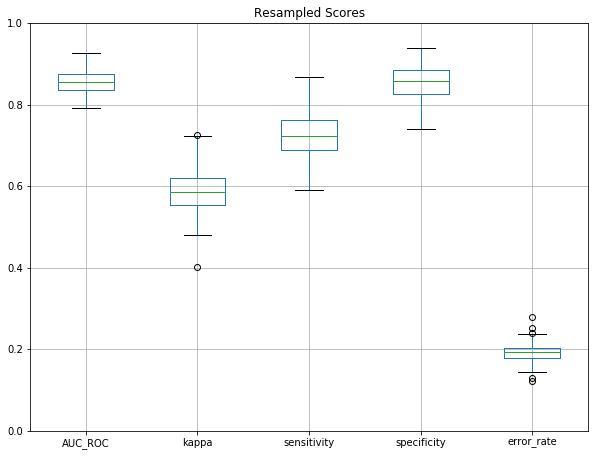

In [11]:
resampler.results.plot_resampled_scores()

# Decorators

In object-oriented programming, the `decorator` pattern is described as a way to "attach additional responsibilities to an object dynamically. Decorators provide a flexible alternative to subclassing for extending functionality." (https://sourcemaking.com/design_patterns/decorator)

We will use a Decorator object to "attach additional responsibility" to a Resampler, dynamically. One example is with a **`TwoClassThresholdDecorator`** class. This Decorator is passed into a Resampler and, for each time the model is trained in the Resampler (i.e., per fold/repeat in the case of a `RepeatedCrossValidationResampler` object), the Decorator calculates the ideal thresholds (at that fold/repeat) that minimize the distance to the upper left corner for the ROC curve, and minimizes the distance to the upper right corner for the Precision/Recall curve (i.e. balancing the inherent trade-offs in both curves).

We can then take, for example, the mean of these thresholds, and use that to convert our predictions DataFrame (that have continuous values for each class, as columns) into specific class predictions.

In [12]:
decorator = TwoClassThresholdDecorator()

# define the transformations
transformations = [RemoveColumnsTransformer(['PassengerId', 'Name', 'Ticket', 'Cabin']),
                   CategoricConverterTransformer(['Pclass', 'SibSp', 'Parch']),
                   ImputationTransformer(),
                   DummyEncodeTransformer(CategoricalEncoding.ONE_HOT)]

# define the scores, which will be used to compare the performance of each fold and overall
# the scores need a Converter, which contains the logic necessary to convert the predicted values to a predicted class.
score_list = [AucRocScore(positive_class='lived'),
              KappaScore(converter=TwoClassThresholdConverter(threshold=0.5, positive_class='lived')),
              SensitivityScore(converter=TwoClassThresholdConverter(threshold=0.5, positive_class='lived')),
              SpecificityScore(converter=TwoClassThresholdConverter(threshold=0.5, positive_class='lived')),
              ErrorRateScore(converter=TwoClassThresholdConverter(threshold=0.5, positive_class='lived'))]

# define & configure the Resampler object
resampler = RepeatedCrossValidationResampler(
    model=RandomForestClassifier(),  # we'll use a Random Forest model
    transformations=transformations,
    scores=score_list,
    folds=5,  # 5 folds with 5 repeats
    repeats=5,
    fold_decorators=[decorator])

# resample
resampler.resample(data_x=data_x, data_y=data_y, hyper_params=RandomForestHP())  # default Random Forest Hyper Parameters

Again, we piggy-backed off of the work that the Resampler is doing anyway, to also give us the ideal thresholds (for both ROC and Precision/Recall Curves) at each fold/repeat, as shown below:

In [13]:
decorator.roc_ideal_thresholds

[0.45,
 0.39,
 0.31,
 0.24,
 0.37,
 0.36,
 0.46,
 0.48,
 0.32,
 0.48,
 0.35,
 0.57,
 0.5,
 0.34,
 0.23,
 0.52,
 0.47,
 0.37,
 0.54,
 0.35,
 0.45,
 0.42,
 0.42,
 0.39,
 0.32]

In [14]:
decorator.precision_recall_ideal_thresholds

[0.45,
 0.44,
 0.31,
 0.24,
 0.53,
 0.36,
 0.46,
 0.63,
 0.76,
 0.48,
 0.54,
 0.59,
 0.5,
 0.46,
 0.71,
 0.52,
 0.6,
 0.39,
 0.68,
 0.27,
 0.5,
 0.42,
 0.42,
 0.39,
 0.56]

We can also easily get the **`mean`**, **`standard deviation`**, and **`coefficient of variation`** associated with each set of ideal thresholds. 

In [15]:
decorator.roc_ideal_thresholds_mean

0.40399999999999997

In [16]:
decorator.resampled_precision_recall_mean

0.48840000000000006

In [17]:
decorator.roc_ideal_thresholds_st_dev

0.08653323061113574

In [18]:
decorator.resampled_precision_recall_st_dev

0.1273005891581025

In [19]:
decorator.roc_ideal_thresholds_cv

0.21

In [20]:
decorator.resampled_precision_recall_cv

0.26